<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A4-Neural-Network-Classifier" data-toc-modified-id="A4-Neural-Network-Classifier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A4 Neural Network Classifier</a></span><ul class="toc-item"><li><span><a href="#NeuralNetworkClassifier" data-toc-modified-id="NeuralNetworkClassifier-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><code>NeuralNetworkClassifier</code></a></span></li><li><span><a href="#percent_correct" data-toc-modified-id="percent_correct-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><code>percent_correct</code></a></span></li><li><span><a href="#Apply-NeuralNetworkClassifier-to-Images-of-Handwritten-Digits" data-toc-modified-id="Apply-NeuralNetworkClassifier-to-Images-of-Handwritten-Digits-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Apply <code>NeuralNetworkClassifier</code> to Images of Handwritten Digits</a></span></li><li><span><a href="#Define-train_for_best_validation-and-apply-to-MNIST-data" data-toc-modified-id="Define-train_for_best_validation-and-apply-to-MNIST-data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Define <code>train_for_best_validation</code> and apply to MNIST data</a></span></li></ul></li><li><span><a href="#Grading" data-toc-modified-id="Grading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

### Suman Bhatta

# A4 Neural Network Classifier

## `NeuralNetworkClassifier`

The NeuralNetwork class defined in Lecture Notes 12 was used for this assignment. NeuralNetworkClassifier subclass is defined. It inherits NeuralNetwork class along with its methods and variables.



In [1]:
import numpy as np
import sys

import pandas
import pickle
import gzip
import matplotlib.pyplot as plt

### NeuralNetwork
Using the NeuralNetwork class provided by professor.

In [2]:
import optimizers as opt

class NeuralNetwork():

    def __init__(self, n_inputs, n_hiddens_list, n_outputs):

        self.n_inputs = n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        self.n_layers = len(n_hiddens_list) + 1

        self.all_weights, self.Ws = self.make_weights()
        self.initialize_weights()
        self.all_gradients, self.Gs = self.make_weights()

        self.stand_params = None
        self.error_trace = []

    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs})'

    def make_weights(self):
        # Create list of matrix shapes, one per layer
        n_in = self.n_inputs
        units = self.n_hiddens_list + [self.n_outputs]
        shapes = []
        for n_units in units:
            shapes.append((n_in + 1, n_units))
            n_in = n_units

        # Allocate contiguous memory to hold all weights
        n_weights = sum([ni * nu for (ni, nu) in shapes])
        all_weights = np.zeros(n_weights)

        # Create numpy views into this memory with the appropriate
        # shapes to be our weight matrices.
        Ws = []
        first = 0
        for (ni, nu) in shapes:
            n_w = ni * nu
            W = all_weights[first:first + n_w].reshape(ni, nu)
            Ws.append(W)
            first += n_w

        return all_weights, Ws

    def initialize_weights(self):
        for W in self.Ws:
            ni, nu = W.shape
            W[:] = np.random.uniform(-1, 1, size=(ni, nu)) / np.sqrt(ni)
        self.error_trace = []

    def forward(self,Xst):
        Ys = [Xst]
        for layer_i, W in enumerate(self.Ws):
            X = Ys[-1]
            Y = self.add_ones(X) @ W
            if layer_i < self.n_layers - 1:
                Y = np.tanh(Y)
            Ys.append(Y)
        return Ys[1:]  # remove X from Ys

    def backward(self, Xst, Tst):
        n_samples = Xst.shape[0]

        Ys = self.forward(Xst)
        Ys = [Xst] + Ys  # Ys now has n_layers + 1 elements. Ws still has n_layers elements.
        delta = - (Tst - Ys[-1]) / (n_samples * self.n_outputs)
        for layeri in range(self.n_layers)[::-1]:
            X = Ys[layeri]
            self.Gs[layeri][:] = self.add_ones(X).T @ delta
            if layeri > 0:
                delta = delta @ self.Ws[layeri][1:, :].T
                Y = X  # Ys[layeri]
                delta *= 1 - Ys[layeri] ** 2
            # if layeri < self.n_layers - 1:
            #     delta *= 1 - Y ** 2
        # print(self.all_gradients)
        return self.all_gradients

    def mse(self, Xst, Tst):
        Yst = self.forward(Xst)
        return 0.5 * np.mean((Tst - Yst[-1])**2)

    def train(self, X, T, n_epochs, learning_rate=0.01, method='scg', verbose=True):

        self.stand_params = self.calc_standardize_parameters(X, T)
        Xst = self.standardize_X(X)
        Tst = self.standardize_T(T)

        if method == 'sgd':
            optimizer = opt.Optimizers(self.all_weights).sgd
        elif method == 'adam':
            optimizer = opt.Optimizers(self.all_weights).adam
        elif method == 'scg':
            optimizer = opt.Optimizers(self.all_weights).scg
        else:
            print('train: method must be \'sgd\', \'adam\', or \'scg\'.')

        def error_convert(err):
            if T.shape[1] == 1:
                return np.sqrt(err) * self.stand_params['Tstds']
            else:
                # Can't unstandardize err if more than one network output
                return np.sqrt(err)
            
        error_trace = optimizer(self.mse, self.backward, [Xst, Tst],
                                n_epochs, learning_rate,
                                error_convert_f=error_convert,
                                verbose=verbose)
        self.error_trace += error_trace
        return self

    def use(self, X, return_hidden_layer_outputs=False):
        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        Y = self.unstandardize_T(Y)
        Zs = Ys[:-1]
        return (Y, Zs) if return_hidden_layer_outputs else Y

    def get_error_trace(self):
        return self.error_trace

    def add_ones(self, X):
        return np.insert(X, 0, 1, axis=1)

    def calc_standardize_parameters(self, X, T):
        Xmeans = X.mean(axis=0)
        Xstds = X.std(axis=0)
        Xstds[Xstds == 0] = np.mean(Xstds[Xstds > 0])
        Tmeans = T.mean(axis=0)
        Tstds = T.std(axis=0)
        return {'Xmeans': Xmeans, 'Xstds': Xstds, 'Tmeans': Tmeans, 'Tstds': Tstds}

    def standardize_X(self, X):
        return (X - self.stand_params['Xmeans']) / self.stand_params['Xstds']

    def unstandardize_X(self, Xst):
        return Xst * self.stand_params['Xstds'] + self.stand_params['Xmeans']

    def standardize_T(self, T):
        return (T - self.stand_params['Tmeans']) / self.stand_params['Tstds']

    def unstandardize_T(self, Tst):
        return Tst * self.stand_params['Tstds'] + self.stand_params['Tmeans']

##### NeurlNetworkClassfifier class. 
It inherits NeuralNetwork class. 

In [3]:
class NeuralNetworkClassifier(NeuralNetwork):
    """ Neural Network classifier class
    """
    def __init__(self, n_inputs, n_hidden_list, uniq_T_len):
        self.classes = None
        self.most_common_class = None

        # Initialize the inhereted class
        super().__init__(n_inputs, n_hidden_list, uniq_T_len)
    
    def train(self, X, T, n_epochs, learning_rate=0.01, method='scg', verbose=True):

        self.stand_params = self.calc_standardize_parameters(X, T)
        Xst = self.standardize_X(X)
        # Tst = self.standardize_T(T)                                  ## CHANGED

        # NEW PART FROM HERE ...

        self.classes, counts = np.unique(T, return_counts=True)
        self.most_common_class = self.classes[np.argmax(counts)]

        if self.n_outputs != len(self.classes):
            raise ValueError(f'''In NeuralNetworkClassifier, the number of outputs must equal
the number of classes in the training data. The given number of outputs
is {self.n_outputs} and number of classes is {len(self.classes)}. Try changing
the number of outputs in the call to NeuralNetworkClassifier().''')

        T_ind_vars = self.make_indicator_variables(T)
  
        #   ... TO HERE
        
        if method == 'sgd':
            optimizer = opt.Optimizers(self.all_weights).sgd
        elif method == 'adam':
            optimizer = opt.Optimizers(self.all_weights).adam
        elif method == 'scg':
            optimizer = opt.Optimizers(self.all_weights).scg
        else:
            print('train: method must be \'sgd\', \'adam\', or \'scg\'.')

        def error_convert(negLL):
            return np.exp(-negLL)                                                    ## CHANGED
            
        error_trace = optimizer(self.neg_log_likelihood, self.backward, [Xst, T_ind_vars],   ## CHANGED
                                n_epochs, learning_rate,
                                error_convert_f=error_convert,
                                verbose=verbose)
        
        self.error_trace += error_trace
        return self

    def make_indicator_variables(self, T):
        '''Assumes argument is N x 1, N samples each being integer class label.'''
        # Make sure T is two-dimensional. Should be n_samples x 1.
        if T.ndim == 1:
            T = T.reshape((-1, 1))    
        return (T == np.unique(T)).astype(int)

    def forward(self, Xst):
        # call the super forward and apply softmax to the Y
        # Y is list of outputs from forward pass
        Y = super().forward(Xst)
        # Replace the last element by softmax output
        Y[-1] = self.softmax(Y[-1])
        return Y

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = max(0, np.max(Y))
        expY = np.exp(Y - maxY)
        denom = np.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / (denom + sys.float_info.epsilon)  # requires an import sys
        return Y
    
    def neg_log_likelihood(self, Xst, T):  # T must be indicator variables
        Y = self.forward(Xst)
        y_logs = np.log(Y[-1] + sys.float_info.epsilon)
        ret  = -(np.mean(np.multiply(y_logs, T)))
        return (ret)

   # define out of class
    def confusion_matrix(self, Y_classes, T):
        class_names = np.unique(T)
        table = []
        for true_class in class_names:
            row = []
            for Y_class in class_names:
                row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
            table.append(row)
        conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
        # cf.style.background_gradient(cmap='Blues').format("{:.1f} %")
        print('Percent Correct')
        return conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")


    def use(self, X, return_hidden_layer_outputs=False):
        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]

        # Predicted classes
        classes = self.classes[np.argmax(Y, axis=1)].reshape(-1,1)

        Zs = Ys[:-1]
        return (classes, Y, Zs) if return_hidden_layer_outputs else (classes, Y)
    

### `percent_correct`

When trying to classify real data, we need a way to evaluate our performance.  One way is to just calculate the percent of samples correctly classified, and to show a confusion matrix.  Define the function
`percent_correct(Y, T)`, that returns the percent of samples correctly classified, given `T` as a column matrix of class labels, and `Y` as the column matrix of classes predicted by `use`.

In [4]:
#Percent correct
def percent_correct(X, T):
    # Make sure both are column matrix
    X = X.reshape(-1,1)
    T = T.reshape(-1,1)
    pc = 100 * np.mean((np.equal(X, T)).astype(int))
    return(pc)

### `confusion_matrix`
A second way to evaluate a classifier is to calculate a confusion matrix. This shows the percent accuracy for each class, and also shows which classes are predicted in error.

Here is a function to show a confusion matrix.

In [5]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    # cf.style.background_gradient(cmap='Blues').format("{:.1f} %")
    print('Percent Correct')
    return conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")

### Apply `NeuralNetworkClassifier` to Images of Handwritten Digits

The `NeuralNetworkClassifier` is applied to the [MNIST digits dataset](http://deeplearning.net/tutorial/gettingstarted.html) for this assignment. The data was dowloaded and training_set, validation_set and test_sets were separated.

In [6]:
import pickle
import gzip

In [7]:
# Open the MNIST digits dataset and generate Training, Validation and Test dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 784) (50000, 1) (10000, 784) (10000, 1) (10000, 784) (10000, 1)


In [8]:
# Function to draw the images in the dataset
def draw_image(image, label):
    plt.imshow(-image.reshape(28, 28), cmap='gray')
    # plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title(label)

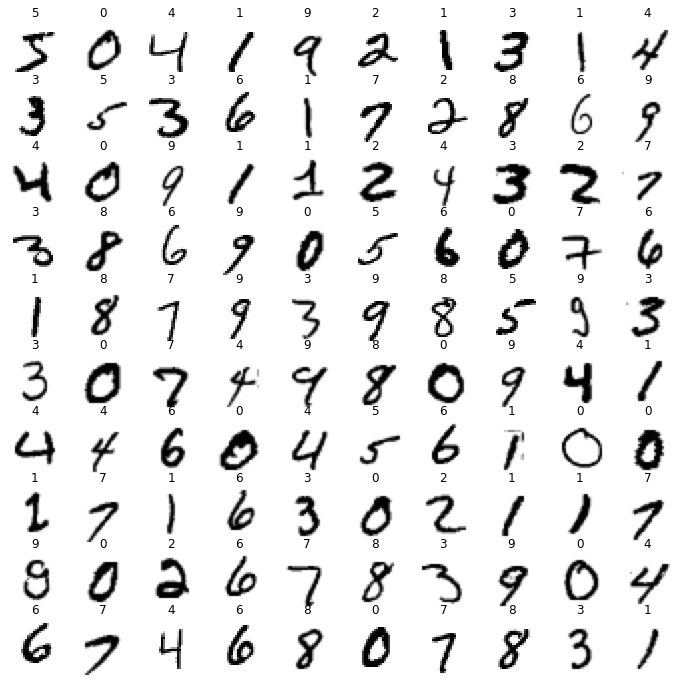

In [9]:
plt.figure(figsize=(12, 12))
for i in range(100):
    plt.subplot(10, 10, i+1)
    draw_image(Xtrain[i], Ttrain[i,0])

### Define `train_for_best_validation` and apply to MNIST data

Using the function `run` from Lecture Notes 11 as a guide, define a new function `train_for_best_validation` that accepts arguments
* `Xtrain, Ttrain`: matrices of shapes $N\times D$ and $N\times 1$ as input and target training data, where $N$ is number of training samples and $D$ is number of input components,
* `Xval, Tval`: matrices of shapes  $N\times D$ and $N\times 1$ of validation data ($N$ not same value as above)
* `n_epochs`: total number of epochs to train for,
* `n_epochs_per_train`: divide `n_epochs` by this value to get number of times the neural network `train` functin is called for this many epochs,
* `n_hiddens_list`: structure of hidden layers,
* `method`: optimizer method,
* `learning_rate`: used for optimizer methods 'adam' and 'sgd'.

It must return 
* `nnet`: resulting neural network with weights that produced the highest accuracy for the validation data set,
* `epoch`: epoch corresponding to best validation accuracy,
* `train_accuracy`: accuracy at that best epoch on training data,
* `val_accuracy`: accuracy at that best epoch on validation data.

This function should call your `percent_correct` function to calculate classification accuracies.

Applying it to the MNIST dataset.

#### `train_for_best_validation` 
This function is used to train and validate the MNIST digits datasets and find out the best epoch for which
there is heighest train and test accuracy. The show_plot arument when True shows the plot for each call of the function, and if it is False it doesnot show the plots. To obtain the best test accuracy show_plot was made Flase so that not all the plots are show at once. And for the final result show_plot was made True.

In [10]:
def train_for_best_validation(Xtrain, Ttrain, Xval, Tval,
                              n_epochs,
                              n_epochs_per_train,
                              n_hiddens_list,
                              method,
                              learning_rate=None,
                              show_plot=True):
    
    n_reps = n_epochs // n_epochs_per_train
    n_epochs_last_train = n_epochs - n_reps * n_epochs_per_train
    if n_epochs_last_train > 0:
        n_reps += 1

    nnet = NeuralNetworkClassifier(Xtrain.shape[1], n_hiddens_list, len(np.unique(Ttrain)))
    best_all_weights = nnet.all_weights.copy()
    best_so_far = np.inf

    accuracies = []
    for reps in range(n_reps):
        n_epoch = n_epochs_per_train 
        if n_epochs_last_train > 0 and reps == n_reps-1:
            n_epoch = n_epochs_last_train
            
        nnet.train(Xtrain, Ttrain, n_epoch, learning_rate, method, verbose=False)
        
        train_accuracy = percent_correct(nnet.use(Xtrain)[0], Ttrain)
        val_accuracy = percent_correct(nnet.use(Xval)[0], Tval)
        
        accuracies.append([(reps + 1) * n_epoch, train_accuracy, val_accuracy])
        
        if val_accuracy < best_so_far:
            best_so_far = val_accuracy
            best_all_weights[:] = nnet.all_weights
        
        
    accuracies = np.array(accuracies)
    best_test_index = np.argmax(accuracies[:, -1])
    best_test_epoch, best_test_train_accuracy, best_test_val_accuracy = accuracies[best_test_index, :]
    print(f'Best val accuracy is at epoch {best_test_epoch}', end='')
    print(f' with ACCURACY Train of {best_test_train_accuracy:.2f} and Test of {best_test_val_accuracy:.2f}')
        
    if show_plot:
        plt.plot(accuracies[:, 0], accuracies[:, 1], label='Train')
        plt.plot(accuracies[:, 0], accuracies[:, 2], label='Val')
        plt.legend()
        ymin, ymax = plt.ylim()
        plt.plot([best_test_epoch, best_test_epoch], [ymin, ymax], 'r')
        plt.xlabel(f'Epochs')
        plt.ylabel('ACCURACY')
    
    # Put best weights into nnet
    nnet.all_weights[:] = best_all_weights
    
    return nnet, best_test_epoch, best_test_train_accuracy, best_test_val_accuracy


Call `train_for_best_validation` a number of times to compare accuracies using the three different optimization methods, and a few different values of `n_epochs`, `n_epochs_per_train`, and `n_hiddens_list`, and `learning_rate` when using 'sgd' and 'adam'.  You do not have to find the very best values of these parameters.  For example, for `n_hiddens_list` at least use `[]` (a linear model) and a larger network, like `[100, 100]`.

Show the confusion matrix for the network that gave you the best validation accuracy.

Write at least 10 sentences about what you observe in the accuracy plots, the train, validation and test accuracies, and the confusion matrix.

Best val accuracy is at epoch 5.0 with ACCURACY Train of 76.38 and Test of 9.92
Best val accuracy is at epoch 10.0 with ACCURACY Train of 84.88 and Test of 85.73
Best val accuracy is at epoch 10.0 with ACCURACY Train of 79.19 and Test of 80.81
Best val accuracy is at epoch 5.0 with ACCURACY Train of 12.04 and Test of 9.91
Best val accuracy is at epoch 10.0 with ACCURACY Train of 79.44 and Test of 80.49
Best val accuracy is at epoch 10.0 with ACCURACY Train of 64.71 and Test of 66.06
Best val accuracy is at epoch 10.0 with ACCURACY Train of 51.71 and Test of 53.11
Best val accuracy is at epoch 10.0 with ACCURACY Train of 22.38 and Test of 21.49
Best val accuracy is at epoch 10.0 with ACCURACY Train of 16.92 and Test of 17.44
Best val accuracy is at epoch 10.0 with ACCURACY Train of 68.92 and Test of 70.72
Best val accuracy is at epoch 10.0 with ACCURACY Train of 43.37 and Test of 44.88
Best val accuracy is at epoch 10.0 with ACCURACY Train of 34.85 and Test of 37.45
Best val accuracy is

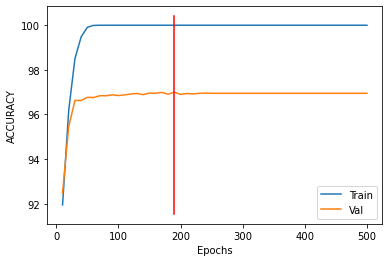

In [11]:
# Run the train_for_best_validation for following parameters
n_epochs_list = [10, 500]
n_epochs_per_train_list = [5, 10]
n_hiddens_lists = [[], [10], [100, 100]]
method_list = ['adam', 'sgd', 'scg']
learning_rate_list = [0.1, 0.25]

# Call train_for_best_validation for various set of parameters

best_val_accuracy = 0
for n_epochs in n_epochs_list:
    for n_epochs_per_train in n_epochs_per_train_list:
        for method in method_list:
            for learning_rate in learning_rate_list:
                for n_hiddens_list in n_hiddens_lists:
                    # Call train_for_best_validation for each set of parameters
                    nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,
                                                                                      Xval, Tval, n_epochs,
                                                                                      n_epochs_per_train,
                                                                                      n_hiddens_list,
                                                                                      method,
                                                                                      learning_rate,
                                                                                      show_plot=False)
                    if val_accuracy > best_val_accuracy:
                        # save the parameters
                        best_val_accuracy = val_accuracy

                        save_method = method
                        save_n_epoch = n_epochs
                        save_learning_rate = learning_rate
                        save_n_hidden_list = n_hiddens_list
                        save_n_epochs_per_train = n_epochs_per_train
                
print("Best validation accuracy and parameter")
print("Best validation accuracy: {} ".format(best_val_accuracy))
print("Method {} ".format(save_method))
print("Epoch {} ".format(save_n_epoch))
print("Learning rate {} ".format(save_learning_rate))
print("Hidden_list {} ".format(save_n_hidden_list))
print("Epoch_per_train {} ".format(save_n_epochs_per_train))

# Run the train_for_best_validation for best validation accuracy
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,
                                                                    Xval, Tval, save_n_epoch,
                                                                    save_n_epochs_per_train,
                                                                    save_n_hidden_list,
                                                                    save_method,
                                                                    save_learning_rate,
                                                                    show_plot=True)




In [12]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]

[91.948, 92.49000000000001, 91.95]

In [13]:
confusion_matrix(nnet.use(Xval)[0], Tval)

Percent Correct


### Description of the result

The MNIST dataset was divided into Training, testing and validation data sets. The dataset was classified using the NeuralNetworkClassifier class. The percent_correct function gives the accuracy of the classification where as overall performance of the neuralnetwork Classifier is given by Confusion matrix. The MNIST dataset was classified using various parameters such as number of epochs, number of hidden lists and number of learning rates (for SGD and ADAMs) for SGD, ADAMs and SGD methods.

When trained for higher number of hidden units and hidden layers, the accuracy of validation data classification was observed to be higer in comparision to less number of hidden units and hidden layers. The linear model does not classify the data properly. When higher number of epochs are used the Neural NetworkClassifier class gives better results in comparision to lower number of epochs.

The plot of the accuracy of Training data and Validation data was observed. The epoch when both the accuracies are maximum is recorded. The accuracy plot shows that, the training and validation accuracy is maximum at epoch 190. As the epoch increases, the accuracy of the validation decreases. Though the training accuracy looks like is increasing, but the validation accuracy decreases after that point. 

The SCG method gives best test accuracy of 97.0 % at epoch count of 500, hidden layers \[ 100,100 \], learning_rate of 0.1 and Epoch_per_train of 10. The percent correct for such method at such network conditions is 91.948 for Train, 92.490 for Validation, and 91.95 Test data. further confusion matrix of the neural network shows the performance of Neural Network.

The confusion matrix is a summary of prediction results on a classification datasets. The confusion matrix shows a ways in which the classification model is confused when it makes predictions. It can be used to measure the performance of an neural network algorithm. The confusion matrix shows that which class was predicted accuractly or inaccuractly by how much percentage.

# Grading

Download [A4grader.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A4grader.tar), extract `A4grader.py` before running the following cell.


======================= Code Execution =======================

Extracting python code from notebook named 'Bhatta-A4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

## Testing constructor ####################################################################

    # Linear network
    nnet = NeuralNetworkClassifier(2, [], 5)
    # Is isinstance(nnet, NeuralNetwork) True?


--- 5/5 points. NeuralNetworkClassifier is correctly of type NeuralNetwork

## Testing constructor ####################################################################

    # Linear network
    nnet = NeuralNetworkClassifier(2, [], 5)
    W_shapes = [W.shape for W in nnet.Ws]


--- 5/5 points. W_shapes is correct value of [(3, 5)]

## Testing constructor ####################################################################

    G_shapes = [G.shape for G in nnet.Gs]


--- 5/5 points. G_shapes is correct value of [(3, 5)]

## Testing train #########

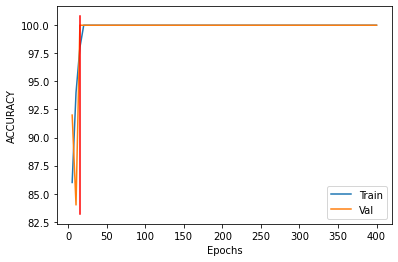

In [19]:
%run -i A4grader.py

# Extra Credit

Repeat the above experiments with a different data set.  Randonly partition your data into training, validaton and test parts if not already provided.  Write in markdown cells descriptions of the data and your results.